In [240]:
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from time import perf_counter
from scipy.fftpack import dctn, idctn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [241]:
original_gray_image = cv2.imread('grey_image.png', cv2.IMREAD_GRAYSCALE)

In [242]:
# Quantization matrix for JPEG
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

In [243]:
keeps = np.linspace(0.01, 0.99, 99)

In [244]:
def average_time(method, *args, iters_number=10):
    times = []
    for i in range(iters_number):
        time_start = perf_counter()
        method(*args)
        time_stop = perf_counter()
        times.append(time_stop - time_start)
    return np.mean(times)

In [245]:
def compression_ratio(size_original, size_compressed):
    return size_compressed / size_original

In [246]:
def compression_factor(size_original, size_compressed):
    return size_original / size_compressed

In [247]:
def PSNR(original_image:np.array, compressed_image:np.array):
    mse = np.mean((original_image - compressed_image) ** 2)
    if mse == 0:  # This means no difference between original and compressed images.
        return float('inf')  
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr

In [248]:
def SSIM(img1, img2, C1=6.5025, C2=58.5225):
    """
    Compute the SSIM between two images.
    
    :param img1: First input image.
    :param img2: Second input image.
    :param C1: Stability constant C1.
    :param C2: Stability constant C2.
    :return: SSIM index.
    """
    # Ensure the input images have the same dimensions
    assert img1.shape == img2.shape, "Input images must have the same dimensions"
    
    # Calculate means
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)
    
    # Calculate variances and covariance
    sigma1_sq = np.var(img1)
    sigma2_sq = np.var(img2)
    sigma12 = np.cov(img1.ravel(), img2.ravel())[0, 1]
    
    # Calculate SSIM
    ssim_numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    ssim_denominator = (mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2)
    ssim = ssim_numerator / ssim_denominator
    
    return ssim

In [249]:
def quantize_image(img, Q):
    height, width = img.shape
    quantized_img = np.zeros_like(img)  # Initialize the quantized image array
    
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            # Extract the 8x8 block from the image
            block = img[i:i+8, j:j+8]
            # Apply the quantization matrix
            quantized_block = np.round(block / Q)
            # Place the quantized block back into the quantized image array
            quantized_img[i:i+8, j:j+8] = quantized_block
            
    return quantized_img

In [250]:
def dct_compress_image_with_thresh(original_image, keep, quantize, Q=None):
    coeffs = dctn(original_image, norm='ortho')
    Csort = np.sort(np.abs(coeffs.reshape(-1)))

    thresh = Csort[int(np.floor((1 - keep) * len(Csort)))]
    ind = np.abs(coeffs) > thresh
    Cfiltered = coeffs * ind

    if quantize and not(Q is None):
        quantize_image(Cfiltered, Q)

    return Cfiltered

def dct_reconstruct_image(coeffs):
    return idctn(coeffs, norm='ortho')

def dct_statistics(original_image, keep, quantize, Q=None):
    Cfiltered = dct_compress_image_with_thresh(original_image, keep, quantize, Q)

    compr_time = average_time(dct_compress_image_with_thresh, original_image, keep, quantize, Q)
    compr_ratio = compression_ratio(Cfiltered.size, np.sum(np.abs(Cfiltered) > 0))
    compr_factor = compression_factor(Cfiltered.size, np.sum(np.abs(Cfiltered) > 0))

    reconstructed_image = dct_reconstruct_image(Cfiltered)

    psnr = PSNR(original_image, reconstructed_image)
    ssim = SSIM(original_image, reconstructed_image)

    return reconstructed_image, compr_time, compr_ratio, compr_factor, psnr, ssim

In [251]:
def fourier_compress_image(original_image, keep, quantize, Q=None):
    coeffs = np.fft.fft2(original_image)
    Csort = np.sort(np.abs(coeffs.reshape(-1)))

    thresh = Csort[int(np.floor((1 - keep) * len(Csort)))]
    ind = np.abs(coeffs) > thresh
    Cfiltered = coeffs * ind

    if quantize and not(Q is None):
        quantize_image(Cfiltered, Q)

    return Cfiltered

def fourier_reconstruct_image(coeffs):
    return np.fft.ifft2(coeffs).real

def fourier_statistics(original_image, keep, quantize, Q=None):
    Cfiltered = fourier_compress_image(original_image, keep, quantize, Q)

    compr_time = average_time(fourier_compress_image, original_image, keep, quantize, Q)
    compr_ratio = compression_ratio(Cfiltered.size, np.sum(np.abs(Cfiltered) > 0))
    compr_factor = compression_factor(Cfiltered.size, np.sum(np.abs(Cfiltered) > 0))

    reconstructed_image = fourier_reconstruct_image(Cfiltered)

    psnr = PSNR(original_image, reconstructed_image)
    ssim = SSIM(original_image, reconstructed_image)

    return reconstructed_image, compr_time, compr_ratio, compr_factor, psnr, ssim

In [252]:
methods = ['DCT', 'Quantized DCT', 'Fourier', 'Quantized Fourier']

compressed_images = {}
compression_times = {}
compression_ratios = {}
compression_factors = {}
psnrs = {}
ssims = {}

for method in methods:
    compressed_images[method] = list()
    compression_times[method] = list()
    compression_ratios[method] = list()
    compression_factors[method] = list()
    psnrs[method] = list()
    ssims[method] = list()

for keep in keeps:
    compr_image, compr_time, compr_ratio, compr_factor, psnr, ssim = dct_statistics(original_gray_image, keep, False)

    compressed_images['DCT'].append(compr_image)
    compression_times['DCT'].append(compr_time)
    compression_ratios['DCT'].append(compr_ratio)
    compression_factors['DCT'].append(compr_factor)
    psnrs['DCT'].append(psnr)
    ssims['DCT'].append(ssim)

    compr_image, compr_time, compr_ratio, compr_factor, psnr, ssim = dct_statistics(original_gray_image, keep, True, Q)

    compressed_images['Quantized DCT'].append(compr_image)
    compression_times['Quantized DCT'].append(compr_time)
    compression_ratios['Quantized DCT'].append(compr_ratio)
    compression_factors['Quantized DCT'].append(compr_factor)
    psnrs['Quantized DCT'].append(psnr)
    ssims['Quantized DCT'].append(ssim)

    compr_image, compr_time, compr_ratio, compr_factor, psnr, ssim = fourier_statistics(original_gray_image, keep, False)

    compressed_images['Fourier'].append(compr_image)
    compression_times['Fourier'].append(compr_time)
    compression_ratios['Fourier'].append(compr_ratio)
    compression_factors['Fourier'].append(compr_factor)
    psnrs['Fourier'].append(psnr)
    ssims['Fourier'].append(ssim)

    compr_image, compr_time, compr_ratio, compr_factor, psnr, ssim = fourier_statistics(original_gray_image, keep, True, Q)

    compressed_images['Quantized Fourier'].append(compr_image)
    compression_times['Quantized Fourier'].append(compr_time)
    compression_ratios['Quantized Fourier'].append(compr_ratio)
    compression_factors['Quantized Fourier'].append(compr_factor)
    psnrs['Quantized Fourier'].append(psnr)
    ssims['Quantized Fourier'].append(ssim)
    

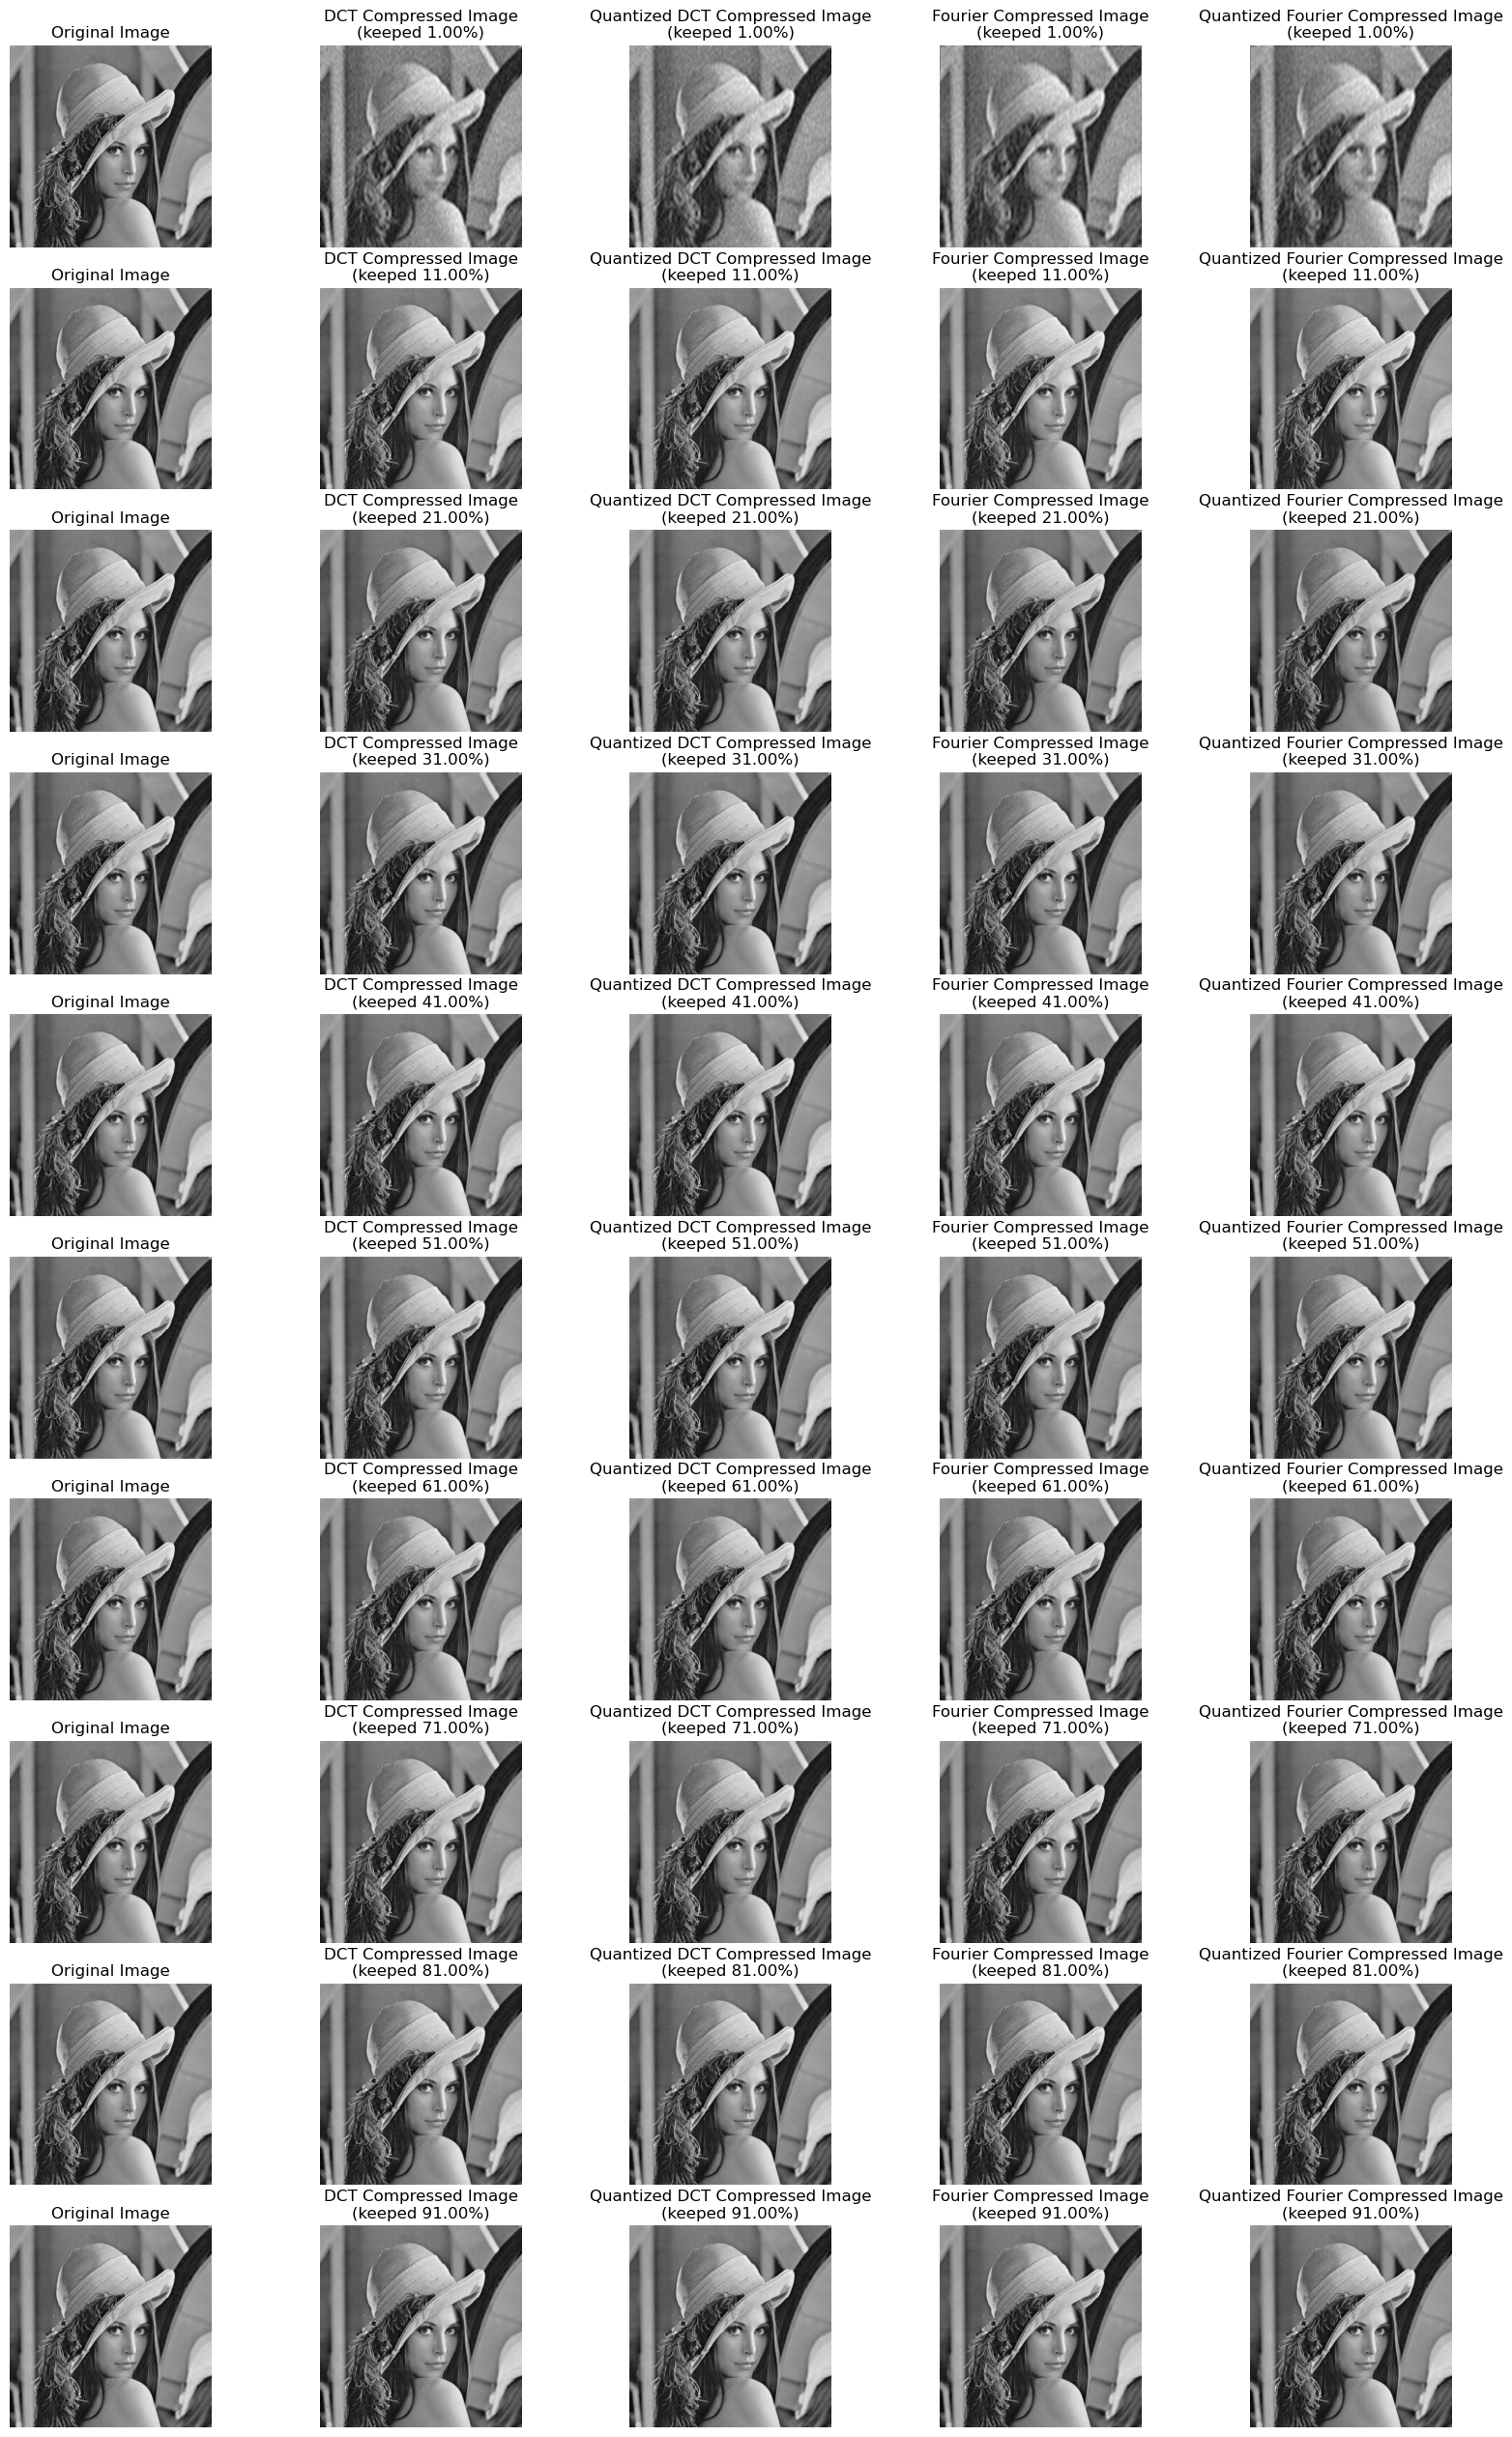

In [253]:
plt.figure(figsize=(20, 32))

for i in range(10):
    plt.subplot(10, 5, 5*i+1)
    plt.imshow(original_gray_image, cmap='gray')
    plt.axis('off')
    plt.title(f'Original Image')

    for j, method in enumerate(methods):
        plt.subplot(10, 5, 5*i + 2 + j)
        plt.imshow(compressed_images[method][i*10], cmap='gray')
        plt.axis('off')
        plt.title(f'{method} Compressed Image\n(keeped {keeps[i*10]*100:.2f}%)')

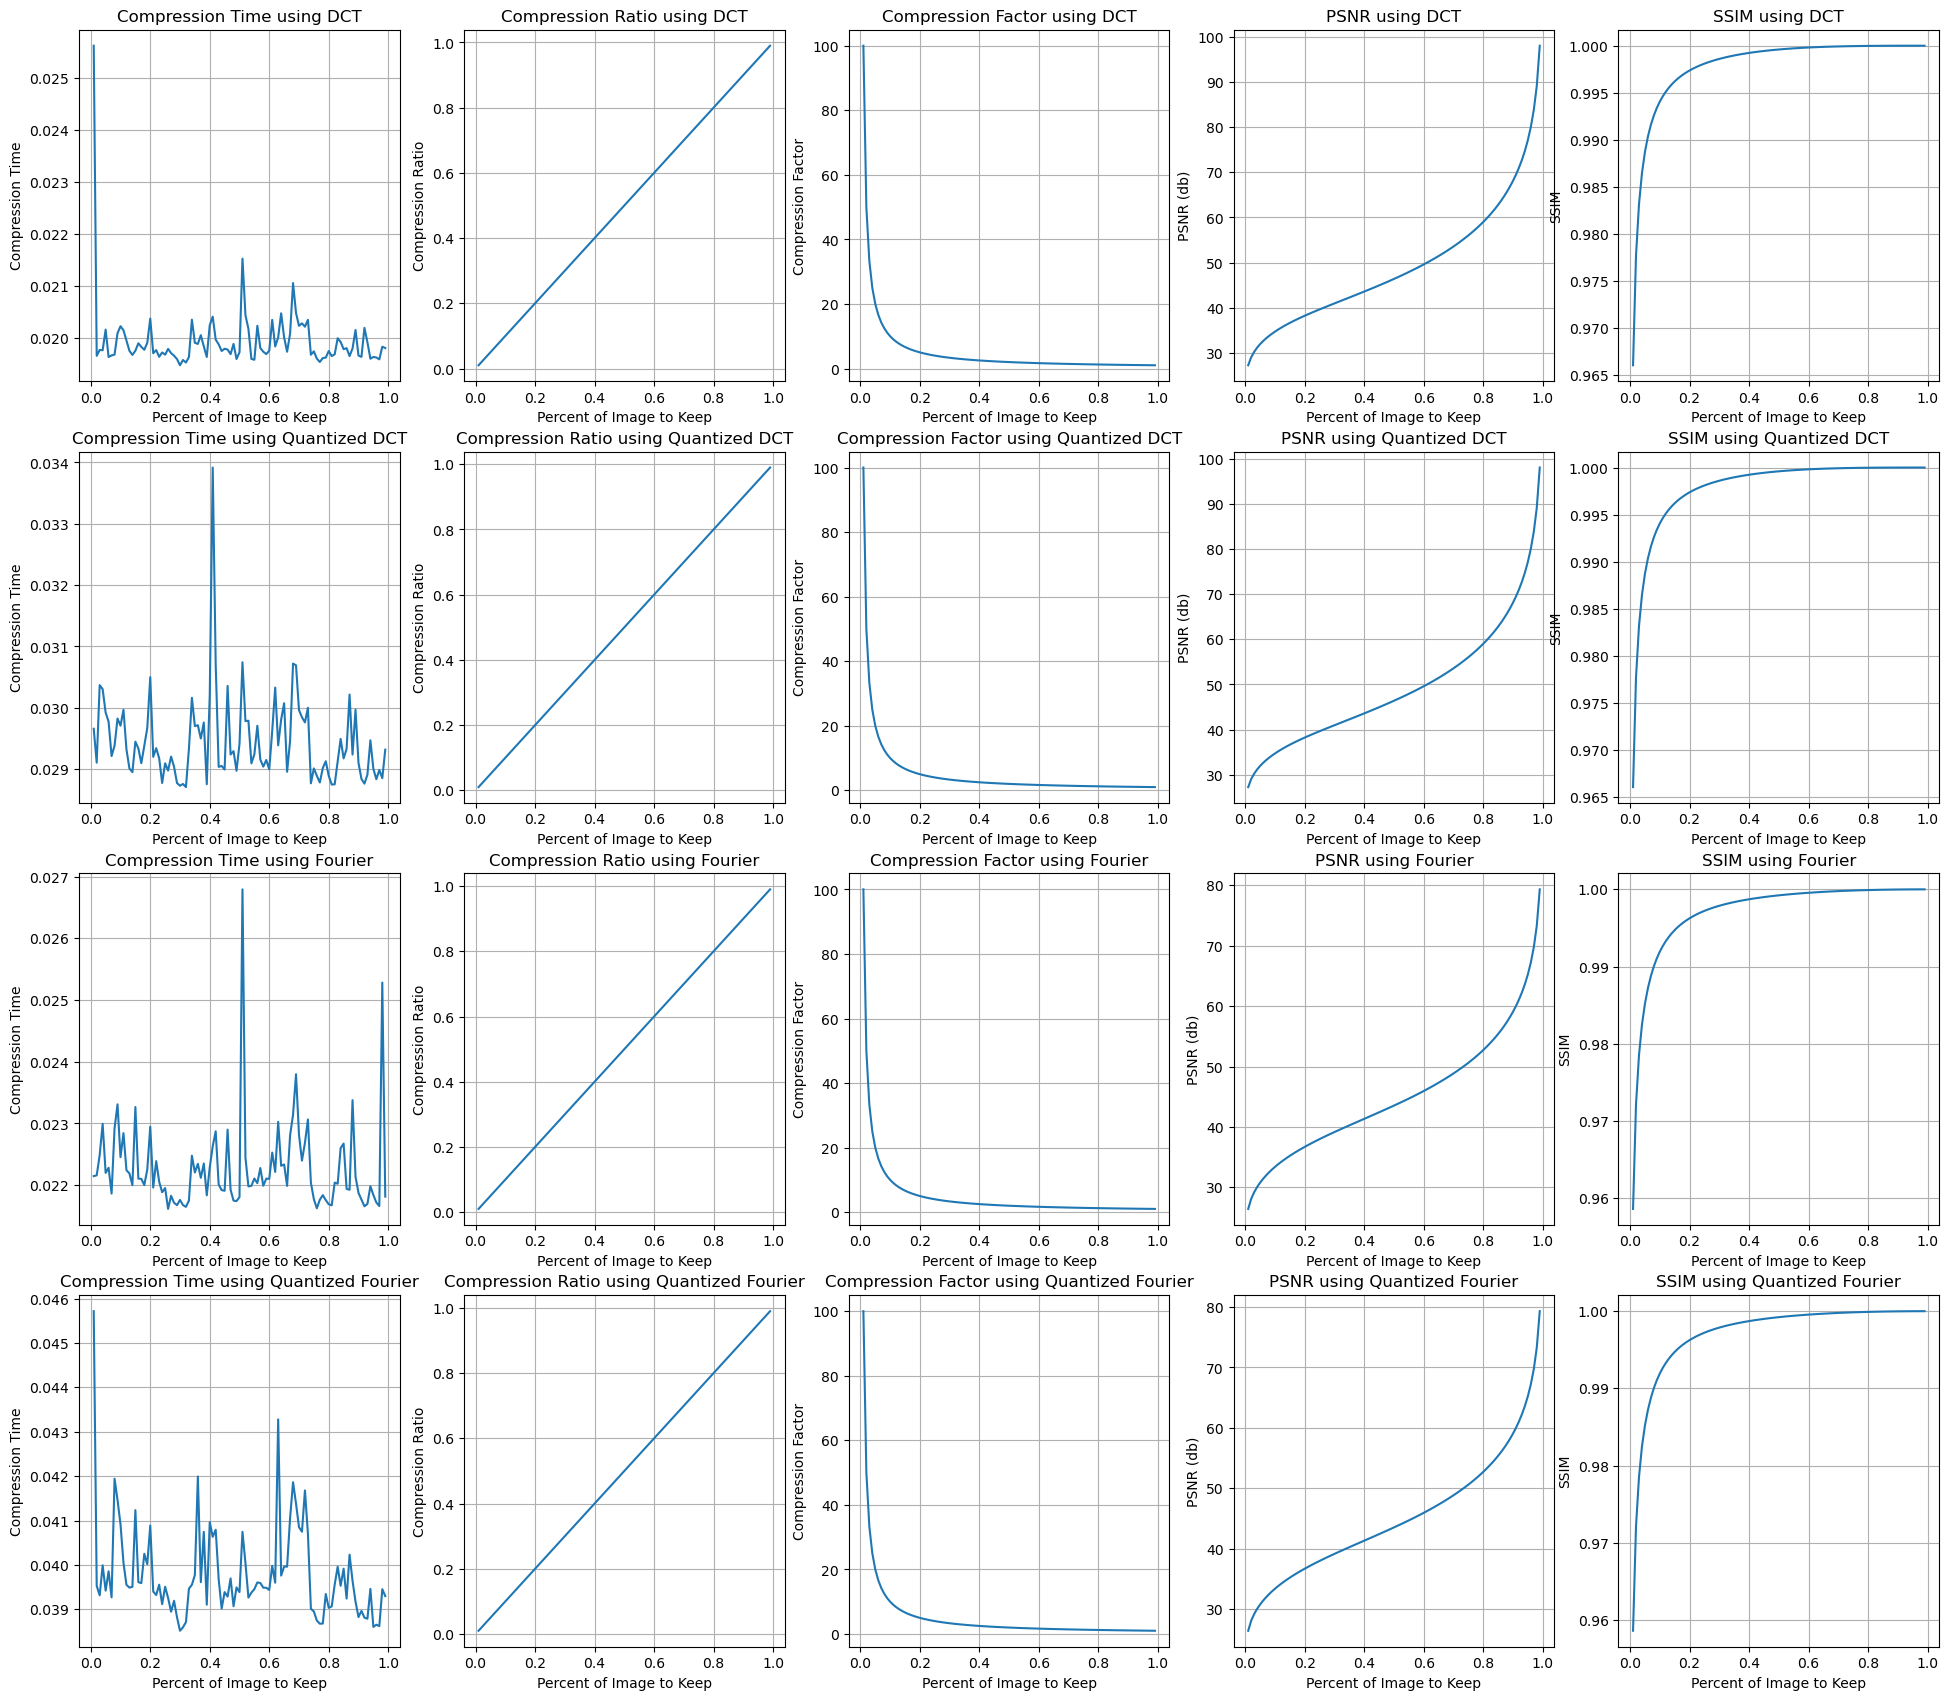

In [254]:
plt.figure(figsize=(24, 21))

for i, method in enumerate(methods):
    plt.subplot(4, 5, 5*i + 1)
    plt.plot(keeps, compression_times[method])
    plt.xlabel('Percent of Image to Keep')
    plt.ylabel('Compression Time')
    plt.title(f'Compression Time using {method}')
    plt.grid(True)

    plt.subplot(4, 5, 5*i + 2)
    plt.plot(keeps, compression_ratios[method])
    plt.xlabel('Percent of Image to Keep')
    plt.ylabel('Compression Ratio')
    plt.title(f'Compression Ratio using {method}')
    plt.grid(True)

    plt.subplot(4, 5, 5*i + 3)
    plt.plot(keeps, compression_factors[method])
    plt.xlabel('Percent of Image to Keep')
    plt.ylabel('Compression Factor')
    plt.title(f'Compression Factor using {method}')
    plt.grid(True)

    plt.subplot(4, 5, 5*i + 4)
    plt.plot(keeps, psnrs[method])
    plt.xlabel('Percent of Image to Keep')
    plt.ylabel('PSNR (db)')
    plt.title(f'PSNR using {method}')
    plt.grid(True)

    plt.subplot(4, 5, 5*i + 5)
    plt.plot(keeps, ssims[method])
    plt.xlabel('Percent of Image to Keep')
    plt.ylabel('SSIM')
    plt.title(f'SSIM using {method}')
    plt.grid(True)


In [255]:
def create_df(keeps, source):
    cols = ['Percentage'] + methods
    df = pd.DataFrame(columns=cols)
    df.set_index('Percentage')

    for i, keep in enumerate(keeps):
        row = {}
        row['Percentage'] = keep
        for method in methods:
            row[method] = source[method][i]
        
        df = df._append(row, ignore_index=True)
    
    return df

In [256]:
df_compression_times = create_df(keeps, compression_times)
df_compression_ratios = create_df(keeps, compression_ratios)
df_compression_factors = create_df(keeps, compression_factors)
df_psnrs = create_df(keeps, psnrs)
df_ssims = create_df(keeps, ssims)

In [257]:
df_compression_times

,Percentage,DCT,Quantized DCT,Fourier,Quantized Fourier
0,0.01,0.025621,0.029658,0.022145,0.045717
1,0.02,0.019662,0.029105,0.022158,0.039528
2,0.03,0.019775,0.030369,0.022485,0.039314
3,0.04,0.019770,0.030303,0.022993,0.039990
4,0.05,0.020165,0.029923,0.022197,0.039420
...,...,...,...,...,...
94,0.95,0.019641,0.029005,0.021839,0.038602
95,0.96,0.019630,0.028835,0.021717,0.038652
96,0.97,0.019595,0.028986,0.021660,0.038621
97,0.98,0.019837,0.028852,0.025283,0.039452


In [258]:
df_compression_ratios

,Percentage,DCT,Quantized DCT,Fourier,Quantized Fourier
0,0.01,0.009998,0.009998,0.009998,0.009998
1,0.02,0.019997,0.019997,0.019993,0.019993
2,0.03,0.029999,0.029999,0.029999,0.029999
3,0.04,0.039997,0.039997,0.039997,0.039997
4,0.05,0.049999,0.049999,0.049999,0.049999
...,...,...,...,...,...
94,0.95,0.949997,0.949997,0.949997,0.949997
95,0.96,0.959999,0.959999,0.959999,0.959999
96,0.97,0.969997,0.969997,0.969997,0.969997
97,0.98,0.980000,0.980000,0.980000,0.980000


In [259]:
df_compression_factors

,Percentage,DCT,Quantized DCT,Fourier,Quantized Fourier
0,0.01,100.016787,100.016787,100.016787,100.016787
1,0.02,50.008394,50.008394,50.017936,50.017936
2,0.03,33.334690,33.334690,33.334690,33.334690
3,0.04,25.001812,25.001812,25.001812,25.001812
4,0.05,20.000305,20.000305,20.000305,20.000305
...,...,...,...,...,...
94,0.95,1.052635,1.052635,1.052635,1.052635
95,0.96,1.041668,1.041668,1.041668,1.041668
96,0.97,1.030931,1.030931,1.030931,1.030931
97,0.98,1.020409,1.020409,1.020409,1.020409


In [260]:
df_psnrs

,Percentage,DCT,Quantized DCT,Fourier,Quantized Fourier
0,0.01,27.261172,27.261172,26.433836,26.433836
1,0.02,29.039048,29.039048,28.098270,28.098270
2,0.03,30.230917,30.230917,29.198651,29.198651
3,0.04,31.168013,31.168013,30.065368,30.065368
4,0.05,31.946817,31.946817,30.783655,30.783655
...,...,...,...,...,...
94,0.95,77.120143,77.120143,65.239591,65.239591
95,0.96,80.040741,80.040741,67.208582,67.208582
96,0.97,83.799603,83.799603,69.732070,69.732070
97,0.98,89.109344,89.109344,73.293981,73.293981


In [261]:
df_ssims

,Percentage,DCT,Quantized DCT,Fourier,Quantized Fourier
0,0.01,0.966010,0.966010,0.958581,0.958581
1,0.02,0.977684,0.977684,0.972136,0.972136
2,0.03,0.983131,0.983131,0.978507,0.978507
3,0.04,0.986450,0.986450,0.982464,0.982464
4,0.05,0.988701,0.988701,0.985178,0.985178
...,...,...,...,...,...
94,0.95,1.000003,1.000003,0.999999,0.999999
95,0.96,1.000004,1.000004,1.000000,1.000000
96,0.97,1.000004,1.000004,1.000002,1.000002
97,0.98,1.000004,1.000004,1.000003,1.000003
